Use the final csv files for train and test and use various models to train and score them

# 1. Import and Load

In [1]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# uncomment to install the three models below >>>>>
# !pip3 install catboost
# !pip install lightgbm
# !pip3 install xgboost
# <<<<<<<<<<<<<<<<<<<<<<<<
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm

# processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# scoring
import math
from sklearn.metrics import r2_score, mean_squared_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap
import datetime

# save model
import pickle
import os
import joblib

In [2]:
TRAIN_PATH = "../Data/microclimate_model/Combined/three_bldgs_dropped.csv"
TEST_PATH = "../Data/microclimate_model/Combined/three_bldgs_J9_dropped.csv"
OUTPUT_PATH = "./output/"

# 2. Data Class

In [3]:

"""
This class encapsulates the datas that we will need for training and testing.
It only contains getters for the train and test data
"""
class Data(object):
    def __init__(self, train_path, test_path, isDropISTB = True):
        """
        Parameters:
            train_path (str) : The file path for the trainning csv file. 
            test_path (str) : The path for the test csv file. 
        
        Both train and test datas have 16 columns with buildings already encoded
        """
        dropped_cols = ['CHWTON/SQM', "bldgname_ISTB 4"]
        if not isDropISTB:
            dropped_cols = ['CHWTON/SQM']
            
        # - Train and validation data
        self.train_val_df = pd.read_csv(train_path, index_col=0)
        self.X_train_val = self.train_val_df.drop(columns=dropped_cols)
        self.y_train_val = self.train_val_df['CHWTON/SQM']  
        
        # - Test data
        self.test_df = pd.read_csv(test_path, index_col=0)
        self.X_test = self.test_df.drop(columns=dropped_cols)
        self.y_test = self.test_df['CHWTON/SQM'] 
        
    
    def get_xy_trainval(self):
        """
        Return the X and y for training data which we can split to train and validation data later.
        """
        return self.X_train_val, self.y_train_val
    
    def get_xy_test(self):
        """
        Return the X and y for June 9th test data
        """
        return self.X_test, self.y_test
        

# 3. Train Test Class

In [4]:
"""
This class encapsulates the the training, testing, and plotting process.
It stores the train and test datas that's already split to X and y
"""
class TrainTest(object):
    def __init__(self, X_train_val, y_train_val, X_test, y_test):
        
        # - scores_df to display the scores for all our models
        self.columns=['model','r2_val', 'r2_test', 'rmse_test','mbe_test']
        self.scores_df= pd.DataFrame(columns=self.columns)
        
        # - train and test data
        self.X_train_val = X_train_val
        self.y_train_val = y_train_val
        self.X_test = X_test
        self.y_test = y_test
        self.tuned_model_list = []
            
    def get_scores_df(self):
        return self.scores_df
    
    
    def train_and_store_score(self, model, model_name):
        """
        This function will train the model given as parameter using the training data. It will compute the r2 validation score
        and append this as a new row to scores_df.
        
        Parameters:
            model (regressor model) : The model object that will be trained and used in validation.
                It can be RF, XGB, LGBM, or catboost regressor
                
            model_name (str) : the name of the model displayed in scores_df
            
        Return:
            model : this is relevant if we are doing randomized search. it will return the best model
        """
        print("\nmodel_name>>>", model_name)
        # 1. Train-Val Split
        X_train, X_val, y_train, y_val = train_test_split(self.X_train_val, 
                                                          self.y_train_val, 
                                                          test_size=0.3, 
                                                          random_state=20)

        # 2. fit model and time it
        start_time = datetime.datetime.now()
        print("start time>>>", start_time)
        model.fit(X_train, y_train)
        end_time = datetime.datetime.now()
        print("end time>>>>", end_time)
        dur_s = (end_time - start_time).total_seconds()
        print("dur", dur_s)
        
        
        # - Get best params if it's a random or grid search
        if(("random" in model_name)) or ("grid" in model_name):
            model = model.best_estimator_
            # print("params", model.get_params())
            
        # 3. get validation R2 score
        val_r2 = model.score(X_val, y_val)
        
        # 4. store score
        new_row_data = {'model':model_name, 
                        "r2_val":val_r2, 
                        "r2_test":0, 
                        'rmse_test':0, 
                        'mbe_test':0, 
                        'train_time_s': dur_s}
        new_row = pd.DataFrame.from_records([new_row_data])
        self.scores_df = pd.concat([self.scores_df, new_row])
        
        return model
    
    def get_MBE(self, y_true, y_pred):
        '''
        Parameters:
            y_true (array): Array of observed values
            y_pred (array): Array of prediction values

        Returns:
            mbe (float): Bias score
        '''
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        y_true = y_true.reshape(len(y_true),1)
        y_pred = y_pred.reshape(len(y_pred),1)   
        diff = (y_pred-y_true)
        mbe = diff.mean()
        return mbe

        
    def test_and_store_score(self, model, model_name):
        """
        This function will use the given trained model to compute the y_pred using the X_test data.
        It will then compute the mbe, r2, and rmse result and insert it to scores_df. 
        
        Parameters:
            model (regressor model): The model that has been trained and will be used to predict y using the test data
                It can be RF, XGB, LGBM, or catboost regressor
            model_name (string): the name of the model displayed in scores_df
        """
        print("\ntest and store scores..", model_name)
        # print(model.get_params())
        # 1. Get prediction for the test data
        y_pred = model.predict(self.X_test)
        
        # 2. get the three scores
        r2 = r2_score(self.y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(self.y_test, y_pred))
        mbe = self.get_MBE(self.y_test, y_pred)
        print("r2 test=", r2)
        
        # 3. update scores_df with the 3 scores above
        row_to_update = self.scores_df["model"] == model_name
        
        
        if row_to_update.empty:
            # append just the test score
            new_row_data = {'model':model_name, 
                        "r2_val":0, 
                        "r2_test":r2, 
                        'rmse_test':rmse, 
                        'mbe_test':mbe, 
                        'train_time_s': 0}
            new_row = pd.DataFrame.from_records([new_row_data])
            self.scores_df = pd.concat([self.scores_df, new_row])
            
        else:
            col_to_update = ['r2_test','rmse_test', 'mbe_test']
            self.scores_df.loc[row_to_update, col_to_update] = [r2, rmse, mbe]
        
        
    def train_test_models(self, model_list):
        """
        This function will take a list of models and train them. if the model is from randomized search, it will
        return the model with best params. This best model will be used to test and store score.
        Using the same model, it will plot the SHAP values.
        
        Parameters:
            model_list (regressor models): list of all models that will be trained, tested, and plot the SHAP values
                It can be RF, XGB, LGBM, or catboost regressor        
        """
        
        for model_name, model in model_list:
            # - need to do this in case its randomized search
            best_model = self.train_and_store_score(model, model_name)
            
            # - assign the model_list so we can get the best 2
            self.tuned_model_list.append((best_model, model_name))
            
            self.test_and_store_score(best_model, model_name)
            
            
    def get_bestN_random_models(self, n):
        """
        This function will take the best four of r2_test score, grab the name of the models, 
        and return the actual regressor object
        
        Parameters:
            model_list (regressor models): list of two models and its name as tuple from randomized search        
        """
        # 0. convert columns to numeric
        col_to_numeric = ["r2_val", "r2_test", "rmse_test", "mbe_test"]
        self.scores_df[col_to_numeric] = self.scores_df[col_to_numeric].apply(pd.to_numeric)
        
        # 1. get best 4 r2
        score_best4 = scores_df.nlargest(4, "r2_test")
        
        # 2. get names best2 of randoms
        best_random_model_names = []
        for row_i in range(n):
            
            # 3. within the best 4 models, get the best two of random
            if score_best4.iloc[row_i, 0][-6:] == "random":
                best_random_model_names.append(score_best4.iloc[row_i, 0])
        
        print("best_random_model_names", best_random_model_names)
        
        # 4. get the model
        best_random_models = []
        
        for tuned_model, model_name in self.tuned_model_list:
            
            if model_name in best_random_model_names:
                print("model_name", model_name)
                best_random_models.append((tuned_model, model_name))
                
        return best_random_models
    
    def get_tuned_models(self):
        return self.tuned_model_list
        

# 5. Model Class

In [5]:
# - for data
DROP_ISTB = True

# - for randomized search
CV = RepeatedKFold(n_splits=10, n_repeats=3)
# CV = 3
N_ITER = 10

# - for base model
RANDOM_STATE = 42
N_ESTIMATORS = 100

In [6]:
class Model():
    def __init__(self, name, base_model, random_grid, cv, n_iter):
                
        # - base model
        self.base_name = name + "_base"
        self.base = base_model
        
        # - randomized search model
        self.random_name = name + "_random"
        
        
        self.random = RandomizedSearchCV(
                            estimator = self.base,
                            param_distributions = random_grid,
                            n_iter = n_iter,
                            cv = cv,
                            verbose = 0,
                            random_state = 42,
                            # scoring ='r2',
                            n_jobs = -1)
        
        # - grid search model
        self.grid_name = name + "_grid"
        self.reg_grid = None
        
        
        
    def set_get_reg_grid(self, grid_param):
        self.reg_grid = GridSearchCV(
                        estimator =self.base,
                        param_grid = grid_param,
                        cv = self.cv,
                        scoring ='r2',
                        n_jobs = -1)
        
        return self.reg_grid
    
    
    # model getters
    def get_base_model(self):
        return self.base
    
    
    def get_random_model(self):
        return self.random
    
    def get_grid_model(self):
        return self.grid
    
    
    # name getters
    def get_base_name(self):
        return self.base_name
    
    def get_random_name(self):
        return self.random_name

    
    def get_grid_name(self):
        return self.grid_name
    
    

# 6. Config for all models

In [7]:
# RF
# A. base model
rf_name = "rf"
rf_base = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

# B. grid for random model
rf_random_grid = {
                
                'criterion': ['squared_error', 'absolute_error', 'poisson'],
                'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)],
                'max_features': ["sqrt", "log2", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [ 1, 2, 4],
                'bootstrap': [True] 
}




In [8]:
# GB
gb_name = "gb"
gb_base = GradientBoostingRegressor(n_estimators = N_ESTIMATORS, random_state = RANDOM_STATE)
gb_random_grid = {
    'learning_rate' : [0.1, 0,2 ,0.3, 0.4],
    'n_estimators':[ 100, 250, 500, 1000],
    'min_child_weight':[1, 2, 4, 5, 8], 
    'max_depth': [4,6,7,8],
    'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7, 1 ],
    'booster': ['gbtree', 'gblinear'] }

In [9]:
# XGB
xgb_name = "xgb"
xgb_base = XGBRegressor(n_estimators = N_ESTIMATORS, verbosity = 0, random_state = RANDOM_STATE)

xgb_random_grid = {
    'learning_rate' : [0.1, 0,2 ,0.3, 0.4],
    'n_estimators':[ 100, 250, 500, 1000],
    'min_child_weight':[1, 2, 4, 5, 8], 
    'max_depth': [4,6,7,8],
    'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7, 1 ],
    'booster': ['gbtree', 'gblinear'] }


In [10]:
# LGBM
# A. base model
lgbm_name = "lgbm"
lgbm_base = LGBMRegressor(random_state = RANDOM_STATE)

# B. grid for random model
lgbm_random_grid = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
                'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
                'num_leaves': [10,15,20,30,40], 
                'min_child_samples': [10,20,40,50,100],
                'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
                'subsample': [0.1, 0.3, 0.8, 1.0], 
                'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
                'colsample_bytree': [0.4, 0.5, 0.6, 1.0],
                'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


In [11]:
# CATBOOST
# A. base model
catboost_name = "catboost"
catboost_base = CatBoostRegressor(random_state = RANDOM_STATE, verbose=False)


# B. Randomized tuned model 
catboost_random_grid = {
        'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
        'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}


# 7. Run models

## Note:
1. drop istb_4 column since its redundant. increased the RF test result.
2. changed the randomized search cv for RF. now the result is quite good


In [12]:
# 1. get train_val and test datas
data_obj = Data(TRAIN_PATH, TEST_PATH, isDropISTB = DROP_ISTB)
X_train_val, y_train_val = data_obj.get_xy_trainval()
X_test, y_test = data_obj.get_xy_test()

# 2. init the trainTest object with the loaded datas
tt = TrainTest(X_train_val, y_train_val,X_test, y_test)

# 3. init model object
RF = Model(rf_name, rf_base, rf_random_grid, CV, N_ITER)
XGB = Model(xgb_name, xgb_base, xgb_random_grid, CV, N_ITER)
LGBM = Model(lgbm_name, lgbm_base, lgbm_random_grid, CV, N_ITER)
CB = Model(catboost_name, catboost_base, catboost_random_grid, CV, N_ITER)

# 4. append all base and random version of each models
# model_objects = [RF, XGB, LGBM, CB]
model_objects = [RF, XGB, LGBM, CB]


all_base_random = []

for model in model_objects:
    base_name, base_model = model.get_base_name(), model.get_base_model()
    random_name, random_model = model.get_random_name(), model.get_random_model()
    all_base_random.extend([(base_name, base_model), (random_name, random_model)])
    # all_base_random.extend([(base_name, base_model)])


# 5. train, test all models
tt.train_test_models(all_base_random)



model_name>>> rf_base
start time>>> 2022-11-21 19:15:55.869491
end time>>>> 2022-11-21 19:15:56.287432
dur 0.417941

test and store scores.. rf_base
r2 test= 0.9680158827405589

model_name>>> rf_random
start time>>> 2022-11-21 19:15:56.306069
end time>>>> 2022-11-21 19:18:19.178191
dur 142.872122

test and store scores.. rf_random
r2 test= 0.9790017749569845

model_name>>> xgb_base
start time>>> 2022-11-21 19:18:19.223222
end time>>>> 2022-11-21 19:18:19.472743
dur 0.249521

test and store scores.. xgb_base
r2 test= 0.9800049511308667

model_name>>> xgb_random
start time>>> 2022-11-21 19:18:19.478545
end time>>>> 2022-11-21 19:18:26.671074
dur 7.192529

test and store scores.. xgb_random
r2 test= 0.9804095814324724

model_name>>> lgbm_base
start time>>> 2022-11-21 19:18:26.676454
end time>>>> 2022-11-21 19:18:27.931916
dur 1.255462

test and store scores.. lgbm_base
r2 test= 0.9751894167631733

model_name>>> lgbm_random
start time>>> 2022-11-21 19:18:27.938163
end time>>>> 2022-11-21 

# 8. Save Scores

In [13]:
scores_df = tt.get_scores_df()
scores_df.to_csv(OUTPUT_PATH + 'scores.csv', index=False)
print(scores_df)


             model    r2_val   r2_test rmse_test  mbe_test  train_time_s
0          rf_base   0.98629  0.968016  0.001607  0.000829      0.417941
0        rf_random  0.986923  0.979002  0.001302   0.00053    142.872122
0         xgb_base  0.984482  0.980005  0.001271  0.000668      0.249521
0       xgb_random   0.98509   0.98041  0.001258  0.000482      7.192529
0        lgbm_base  0.985652  0.975189  0.001415  0.000737      1.255462
0      lgbm_random   0.98456  0.980503  0.001255  0.000442      5.114200
0    catboost_base  0.987611  0.982706  0.001182  0.000506      1.552583
0  catboost_random  0.987739  0.985083  0.001097  0.000407    409.190253


# 9. Save all Models

In [14]:
all_models = tt.get_tuned_models()
# set file 
lgbm = None
for model, name in all_models:

    if "random" in name:
        print("name=", name)
        # 1. double check score
        tt.test_and_store_score(model, name)

        # 2. assign filepath
        # "./output/model/<modelname>.sav
        filepath = OUTPUT_PATH + "model/"
        isExist = os.path.exists(filepath)

        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(filepath)


        # 3. save
        if "lgbm" in name:
            print("lgbm>>")
            # -set filename
            filename = name + ".txt"
            
            # - save model
            model.booster_.save_model(filepath + filename)
            
            # - validate
            print("print path=", filepath + filename)
            model = lightgbm.Booster(model_file=filepath + filename)
            tt.test_and_store_score(model, name)
            lgbm = model


            
        else:
            # - set filename
            filename = name + ".sav"
            
            # - save to the model to filepath
            pickle.dump(model, open(filepath + filename, 'wb'))


    

name= rf_random

test and store scores.. rf_random
r2 test= 0.9790017749569845
name= xgb_random

test and store scores.. xgb_random
r2 test= 0.9804095814324724
name= lgbm_random

test and store scores.. lgbm_random
r2 test= 0.9805034327546807
lgbm>>
print path= ./output/model/lgbm_random.txt

test and store scores.. lgbm_random
r2 test= 0.9805034327546807
name= catboost_random

test and store scores.. catboost_random
r2 test= 0.9850831103533487


In [ ]:
# PLOT LGBM

In [22]:
class Plot():
    def __init__(self, train_path, test_path):
        """
        The constructor will take the file path and create a df with only bldgname as the column.
        So we will only have the following column when plotting:
        ["bldgname", "y_pred", "y_actual" or "y_scenario_prediction"]
        """
        
        def undummify(df, prefix_sep="_"):
            """
            Inner function to undummify pandas df
            
            Return:
                undummified_df: the undummied df containing only date_time as index and bldgname column
            """
            cols2collapse = {
                item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
            }
            series_list = []
            for col, needs_to_collapse in cols2collapse.items():
                if needs_to_collapse:
                    undummified = (
                        df.filter(like=col)
                        .idxmax(axis=1)
                        .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                        .rename(col)
                    )
                    series_list.append(undummified)
                else:
                    series_list.append(df[col])
            undummified_df = pd.concat(series_list, axis=1)
            return undummified_df
        
        
        # 1. create df undumify df that has bldgnmae and index
        # we will use this df for plotting
        data_istb4 = Data(train_path, test_path, isDropISTB=False)
        X_test_istb4, y_test_istb4 = data_istb4.get_xy_test()
        self.df_undum = undummify(X_test_istb4)
        
        # - drop all the columns apart from bldgname with date_time as index
        cols_to_keep = ["bldgname"]
        self.df_undum = self.df_undum.drop(self.df_undum.columns.difference(cols_to_keep), 1)
        
        
        # 2. create df_bldgs pred and actual
        self.df_bldgs = []
        
        
    def get_df_bldgs(self):
        return self.df_bldgs
    
    
    def plot(self, y_pred, y_actual_or_scen, 
             scene_name, 
             output_path="",
             is_scenario=False, 
             is_save=False):
        
            
        # 1. create a copy
        df_undum = self.df_undum.copy()
        
        # 2. assign the first column name
        first_plot_name = "Predicted"
        df_undum[first_plot_name] = y_pred
        
        
        # 3. assign the second column name
        if is_scenario :
            second_plot_name = "Scenario Prediction"
        else:
            second_plot_name = "Actual"

        df_undum[second_plot_name] = y_actual_or_scen
        
        # 4. reformat date index for plotting
        format_before = '%Y-%m-%d %H:%M:%S'
        format_after = '%H:%M'
        df_undum.index = pd.to_datetime(df_undum.index, 
                                        format = format_before).strftime(format_after)
     
        # 4. for each bldgname, compute the difference, 
        for bldgname in df_undum['bldgname'].unique():
            
            # A. get df by bldg
            df_bldg = df_undum[df_undum['bldgname'] == bldgname]
            avg_diff = 0
            
            # B. compute the difference
            if is_scenario :
                # (scenario - predicted) / predicted
                avg_diff = round(((df_bldg[second_plot_name].mean() - 
                            df_bldg[first_plot_name].mean())/df_bldg[first_plot_name].mean())*100,2)
            else: 
                # (predicted - actual) / actual
                avg_diff = round(((df_bldg[first_plot_name].mean() - 
                            df_bldg[second_plot_name].mean())/df_bldg[second_plot_name].mean())*100,2) 
                
                # - save this df
                self.df_bldgs.append(df_bldg)
            
            # C. predicted plot
            
            ax = df_bldg.plot(y = first_plot_name, label = first_plot_name, 
                        ylabel = 'CHWTON/SQM', title = bldgname + "    [Avg Diff:  " + str(avg_diff) + ' %]')
            
            # D. second plot: Scenario or actual
            df_bldg.plot(y = second_plot_name, label = second_plot_name, ax=ax)
            
            
            # E. save images
            if is_save:
                # "./output/predictions_plot/"+ scene_name + "/"
                save_path = output_path + "predictions_plot/"+ scene_name + "/"
                isExist = os.path.exists(save_path)
                if not isExist:

                   # Create a new directory because it does not exist
                   os.makedirs(save_path)
                
                fig = ax.get_figure()
                fig.savefig(save_path + bldgname +'_' + scene_name + '.png')

In [23]:
# create undummify
"""
This class encapsulates the different scenarios that will be applied to our original data.
We only want to make changes of 0.5 in Air temperature, 0.5 absolute humidity, and 0.2 in shades.
"""
class Scenario():
    def __init__(self, X_test, model):
        # model used to predict
        self.model = model
        
        # data
        # X_test has ISTB_4 if model is CB so we can make scenario prediction
        self.X_test = X_test.copy()
        
        # scenarios
        self.AirTdelta = -0.5 # temperature change
        self.AbsHdelta = -0.5 # absolute humidity
        self.shadeDelta = 0.2
        
    def get_scenario_prediction(self, scenario):
        """
        Given a scenario as a string, this function will make corresponding changes to the X_test dataframe
        and then make prediction using the model initialized in constructor.
        
        Parameter:
            scenario(String) : the variable we want to change in this scenario
            
        Return:
            y_pred_scene : the prediction result
        """
        
        # make copy of X_test_scene so we don't change the actual X_test
        X_test_scene = self.X_test.copy()
        
        # 1. modify X_test according to new scenario
        if scenario == "Air Temp":
            X_test_scene[scenario] += self.AirTdelta
            
        elif scenario == "Abs Hum":
            X_test_scene[scenario] += self.AbsHdelta
        
        elif ("Shade" in scenario):
            print("shade scenario")
            X_test_scene[scenario] += self.shadeDelta
            X_test_scene.loc[X_test_scene[scenario] > 1, scenario] = 1
                
        elif (scenario == "combined"):
            # Air Temp and Abs Hum
            X_test_scene['Air Temp'] = X_test_scene['Air Temp'] + self.AirTdelta
            X_test_scene['Abs Hum'] = X_test_scene['Abs Hum'] + self.AbsHdelta

            # Shading
            shadred = 0.2
            shadcol = ['Shade East', 'Shade West', 'Shade North', 'Shade South']
            for facade in shadcol: 
                X_test_scene[facade] = X_test_scene[facade] + shadred
                X_test_scene.loc[X_test_scene[facade] + shadred > 1, facade] = 1
                
        # 2. make prediction
        y_pred_scene = self.model.predict(X_test_scene)
        return y_pred_scene

In [24]:
data = Data(TRAIN_PATH, TEST_PATH, isDropISTB=True)
X_train_val, y_train_val = data.get_xy_trainval()
X_test, y_test= data.get_xy_test()

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


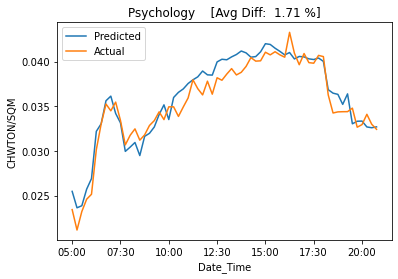

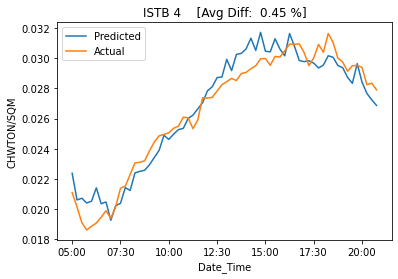

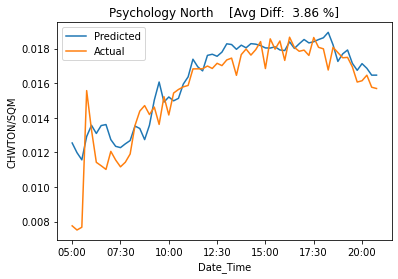

In [25]:
plt_obj = Plot(TRAIN_PATH, TEST_PATH)

# 1. predict
model = lgbm
y_pred = model.predict(X_test)

# 2. plot
plt_obj.plot(y_pred, y_test, 
             scene_name="actual", 
             output_path =OUTPUT_PATH, 
             is_scenario=False, 
             is_save=True)

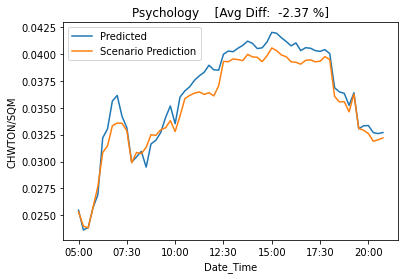

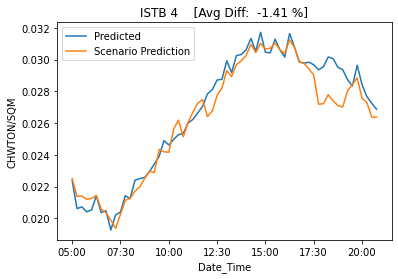

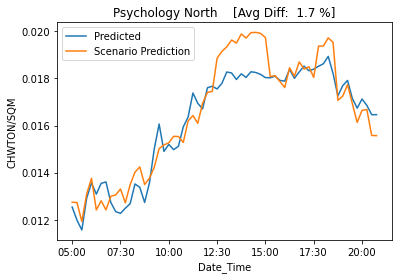

In [26]:
scenario = Scenario(X_test, model)

y_combined_pred = scenario.get_scenario_prediction("combined")
plt_obj.plot(y_pred, y_combined_pred, 
             scene_name="combined", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

# 10.Tuning Best (Catboost)

In [ ]:
cb_reg_grid = {
        'depth': [9,10,11],
        'learning_rate' : [0.02, 0.03, 0.04],
        'l2_leaf_reg': [1, 2],
        'n_estimators' : [400, 500, 600],
        'verbose': [False],
        'loss_function': ['RMSE'],
        }

print(CB.get_base_name())

cb_gridsearch, cb_grid_name = CB.set_get_reg_grid(cb_reg_grid), CB.get_grid_name()
cb_best_grid = tt.train_and_store_score(cb_gridsearch, cb_grid_name)
tt.test_and_store_score(cb_best_grid, cb_grid_name)
tt.explainerObj.plot(cb_best_grid, cb_grid_name)

In [ ]:
scores_df = tt.get_scores_df()
print(scores_df)

In [ ]:
# catboost_best_random = {'learning_rate': 0.03, 
#                       'depth': 6,
#                       'l2_leaf_reg': 1,
#                       'loss_function': 'RMSE',
#                       'verbose': False,
#                       'n_estimators': 1000}
